### import/install

In [ ]:
import torch
import numpy as np
import pandas as pd

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [ ]:
! pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset

# Анализ датасета

In [ ]:
ds = load_dataset("pasinit/scotus")

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'decisionDirection', 'respondent', 'label_ids', 'labels'],
        num_rows: 7417
    })
    validation: Dataset({
        features: ['id', 'text', 'decisionDirection', 'respondent', 'label_ids', 'labels'],
        num_rows: 914
    })
    test: Dataset({
        features: ['id', 'text', 'decisionDirection', 'respondent', 'label_ids', 'labels'],
        num_rows: 931
    })
})

Посмотрим какие типы юридических договоров содержатся в столбце **labels** и какие label_id им соответствуют

In [ ]:
dict(zip(ds['train'].unique('label_ids'), ds['train'].unique('labels')))

{9: 'federalism',
 2: 'first_amendment',
 1: 'civil_rights',
 0: 'criminal_procedure',
 7: 'economic_activity',
 6: 'unions',
 8: 'judicial_power',
 10: 'federal_taxation',
 3: 'due_process',
 4: 'privacy',
 5: 'attorneys'}

Рассмотрим каждый тип метки из датасета SCOTUS

1. **First Amendment (Первая поправка)**:
   - Первая поправка к Конституции США гарантирует свободу слова, свободу вероисповедания, свободу собраний и право на подачу петиций. Документы, связанные с этими правами, могут включать дела о свободе слова, религиозной свободе и праве на мирные собрания.

2. **Judicial Power (Судебная власть)**:
   - Эта категория включает документы, связанные с полномочиями судебной системы, такими как право судов интерпретировать законы, рассматривать дела и выносить решения.

3. **Criminal Procedure (Уголовный процесс)**:
   - Документы в этой категории касаются процедур, связанных с уголовными делами, включая аресты, обыски, судебные разбирательства и приговоры.

4. **Civil Rights (Гражданские права)**:
   - Гражданские права включают защиту от дискриминации по признаку расы, пола, религии, национального происхождения и других характеристик. Документы могут касаться дел о равных возможностях, прав на образование и трудоустройство.

5. **Due Process (Право на справедливый суд)**:
   - Право на справедливый суд гарантирует, что все лица имеют право на справедливое и беспристрастное судебное разбирательство. Документы могут включать дела о процессуальных правах и справедливости судебных процессов.

6. **Unions (Профсоюзы)**:
   - Эта категория включает документы, связанные с правами и деятельностью профсоюзов, включая коллективные переговоры, забастовки и трудовые споры.

7. **Federal Taxation (Федеральное налогообложение)**:
   - Документы в этой категории касаются федеральных налогов, включая подоходный налог, налог на прибыль корпораций и другие федеральные налоги.

8. **Federalism (Федерализм)**:
   - Федерализм касается распределения полномочий между федеральным правительством и правительствами штатов. Документы могут включать дела о полномочиях штатов и федерального правительства.

9. **Economic Activity (Экономическая деятельность)**:
   - Эта категория включает документы, связанные с экономической деятельностью, такими как регулирование бизнеса, антимонопольное законодательство и торговые споры.

10. **Attorneys (Адвокаты)**:
    - Документы в этой категории касаются прав и обязанностей адвокатов, включая этические нормы, профессиональную ответственность и права клиентов.

11. **Privacy (Конфиденциальность)**:
    - Конфиденциальность включает защиту личной информации и права на неприкосновенность частной жизни. Документы могут касаться дел о защите данных, слежке и праве на конфиденциальность.

Эти метки помогают классифицировать юридические документы по тематическим категориям, что облегчает анализ и поиск информации в больших объемах данных.

# Дообучение BERT

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Токенизация текста
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

In [ ]:
tokenized_train = ds['train'].select_columns(['text', 'label_ids']).select(range(2000)).map(tokenize_function, batched=True,  num_proc = 8)
tokenized_test = ds['test'].select_columns(['text', 'label_ids']).select(range(500)).map(tokenize_function, batched=True,  num_proc = 8)

Map (num_proc=8):   0%|          | 0/2000 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
tokenized_train = tokenized_train.remove_columns(['text']).rename_column('label_ids', 'labels')
tokenized_test = tokenized_test.remove_columns(['text']).rename_column('label_ids', 'labels')

In [ ]:
# Загрузка предобученной модели BERT для классификации
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=11)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Определение аргументов для тренировки
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs = 5,
    weight_decay=0.01,
)

In [ ]:
# Создание тренера
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
)

In [ ]:
import wandb

# Инициализация WandB
wandb.init(project="your_project_name")

# Обучение модели
trainer.train()

eval/loss,█▄▁▁
eval/model_preparation_time,▁▁▁▁
eval/runtime,▁▃█▆
eval/samples_per_second,█▆▁▃
eval/steps_per_second,█▆▁▃
train/epoch,▁▅███
train/global_step,▁▅███
eval/loss,1.79438
eval/model_preparation_time,0.0138
eval/runtime,2.8398
eval/samples_per_second,35.214


Epoch,Training Loss,Validation Loss
1,No log,1.198144
2,1.367600,1.031395
3,1.367600,0.908388
4,0.610400,0.928503
5,0.610400,0.929156


TrainOutput(global_step=1250, training_loss=0.8647262817382813, metrics={'train_runtime': 1087.7361, 'train_samples_per_second': 9.193, 'train_steps_per_second': 1.149, 'total_flos': 2631323166720000.0, 'train_loss': 0.8647262817382813, 'epoch': 5.0})

In [ ]:
# Оценка модели
trainer.evaluate()

{'eval_loss': 0.9291560649871826,
 'eval_runtime': 14.7658,
 'eval_samples_per_second': 33.862,
 'eval_steps_per_second': 4.267,
 'epoch': 5.0}

# Конкретные примеры

In [ ]:
inputs = tokenizer(ds['test'].select([2, 3, 10])['text'], return_tensors='pt', padding='max_length', truncation=True)

# Перенос входных данных на GPU, если доступно
inputs = {key: value.to(device) for key, value in inputs.items()}

# Предсказание
with torch.no_grad():
    outputs = model(**inputs)

# Получение предсказанных логов
logits = outputs.logits

prediction = torch.argmax(logits, axis = -1)

In [ ]:
#предсказание классов для этих текстов
prediction

tensor([0, 1, 8], device='cuda:0')

In [ ]:
#реальные классы  этих текстов
a = ds['test'].select([2, 3, 10])
a['label_ids'], a['labels']

([0, 1, 8], ['criminal_procedure', 'civil_rights', 'judicial_power'])

In [ ]:
#это длина в символах этих текстов
len(a['text'][0]), len(a['text'][1]), len(a['text'][2])

(55840, 108794, 186683)

# Оценка модели

In [ ]:
labels = torch.tensor(tokenized_test['labels']).to(device)
inputs = tokenized_test.remove_columns(['labels'])
inputs = {'input_ids' : torch.tensor(inputs['input_ids']).to(device),
          'token_type_ids' : torch.tensor(inputs['token_type_ids']).to(device),
          'attention_mask' : torch.tensor(inputs['attention_mask']).to(device)}

In [ ]:
# Предсказание
with torch.no_grad():
    outputs = model(**inputs)

# Получение предсказанных логов
logits = outputs.logits

# Преобразование логов в вероятности (если это необходимо)
prediction = torch.argmax(logits, axis = -1)

In [ ]:
#ACCURACY
acc = ((labels == prediction).sum() / len(labels)).item()
print(f'TEST ACCURACY = {acc : .1%}')

TEST ACCURACY =  73.4%


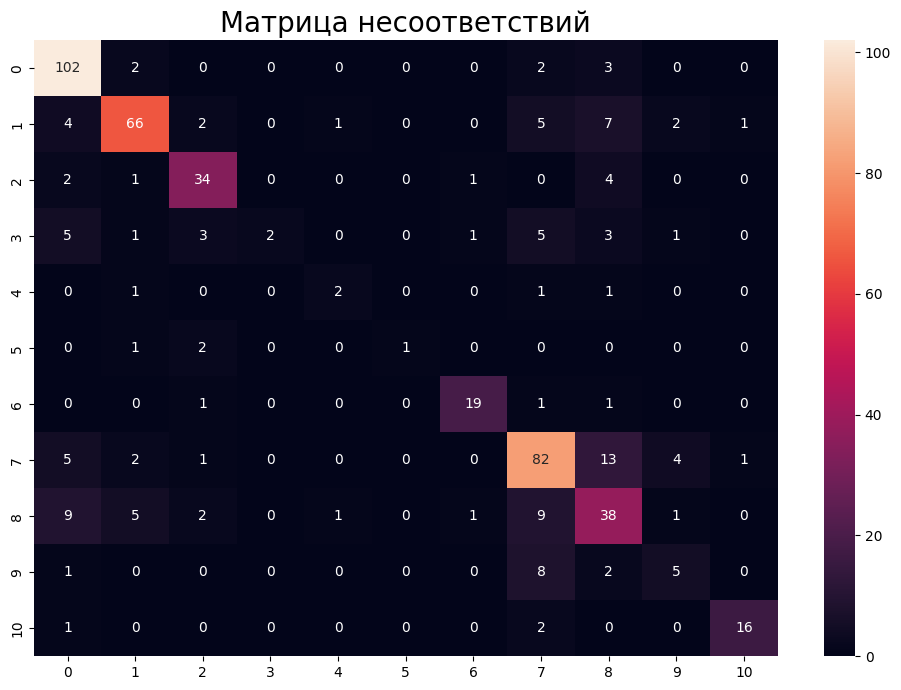

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 8))
plt.title('Матрица несоответствий', fontsize = 20)
sns.heatmap(confusion_matrix(labels.cpu(), prediction.cpu()), fmt = '.3g', annot = True);

    {9: 'federalism',
    2: 'first_amendment',
    1: 'civil_rights',
    0: 'criminal_procedure',
    7: 'economic_activity',
    6: 'unions',
    8: 'judicial_power',
    10: 'federal_taxation',
    3: 'due_process',
    4: 'privacy',
    5: 'attorneys'}

1) В первую очередь выделяется несбалансированность классов в тестовой выборке

2) Если говорить об ошибках выделяются  классы 7, 8
В них было добущено наибольшее их кол-во. Также модель относительно часто путала эти классы между собой



3) Также модел путала, классы 7 и 9.






    7.Economic Activity (Экономическая деятельность):
    Эта категория включает документы, связанные с экономической деятельностью, такими как регулирование бизнеса, антимонопольное законодательство и торговые споры.

    8.Judicial Power (Судебная власть):
    Эта категория включает документы, связанные с полномочиями судебной системы, такими как право судов интерпретировать законы, рассматривать дела и выносить решения.

    9.Federalism (Федерализм):
    Федерализм касается распределения полномочий между федеральным правительством и правительствами штатов. Документы могут включать дела о полномочиях штатов и федерального правительства.